# Trabalho 1 - Método Numéricos (PEC00141)

---

[1.Dados](#section_1)

[2.Inserindo os dados](#section_2)

[3.Plotagem da estrutura](#section_3)

[4.Comprimento das barras e cos e sen diretores](#section_4)

[5.Montagem da matriz de rigidez](#section_5)

[6.Aplicação das condições de contorno](#section_6)

---

## 1. Dados <a name="section_1"></a>
Para a estrutura ilustrada na figura abaixo:
<img src="imagem.PNG" style="width:400px;height:400px"/>
As áreas das barras 1,2 3,4, 5 e 6 em 10E03 mm², são, respectivamente: 25, 30, 30, 25, 30 e 10. E=200GPa.

## 2. Inserindo os dados <a name="section_2"></a>

Importação de módulos que serão utilizados

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

Há 6 barras e 4 nós e 10 gdl (2 por nó). A numeração dos graus de liberdade é feita nó a nó, onde **a direção x tem o primeiro gdl do nó e a direção y o segundo**, dessa forma, a numeração dos gdls para o nó n é dada por:
\begin{align}
gdl_h &= 2n-1\\
gdl_v &= 2n
\end{align}

Importação do excel (as unidades estão em metros e em Newtons):

In [2]:
nos = pd.read_excel('dados_de_entrada.xlsx', sheet_name='Nós')
barras = pd.read_excel('dados_de_entrada.xlsx', sheet_name='Barras')

# Acertando os números dos nós e das barras conforme a figura (iniciando em 1)
nos.index += 1
barras.index += 1

# Trocando celulas vazias por zeros
nos.fillna(0, inplace=True)

# Printando os valores na tela
nos

,X,Y,RX,RY,FX,FY,dx,dy
1,0,0,1.0,1.0,0.0,0.0,0.0,0.0
2,6,0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,4,0.0,0.0,200000.0,0.0,0.0,0.0
4,6,8,0.0,0.0,0.0,0.0,0.0,0.0
5,0,8,1.0,1.0,0.0,0.0,0.0,0.0


In [3]:
barras

,N1,N2,A,E
1,1,2,0.025,200000000000
2,1,3,0.030,200000000000
3,2,3,0.030,200000000000
4,2,4,0.025,200000000000
5,3,4,0.030,200000000000
6,4,5,0.010,200000000000


## 3. Plotagem da estrutura<a name="section_3"></a> 

O código abaixo permite a montagem da estrutura plotando elemento a elemento a partir das matrizes das barras e dos nós.

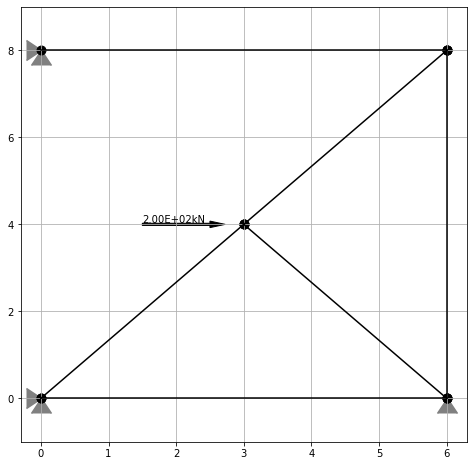

In [4]:
plt.figure(1,figsize=(8,8))
plt.ylim(-1,9)

# Plotagem dos apoios e das forças
for no in nos.index:
    X,Y,RX,RY,Fx,Fy,dx,dy = nos.loc[no]  #percorre os valores de X,Y,RX,RY,Fx,Fy,dx,dy na tabela para cada no do for (1,2,3 e 4)

    # Aplicação dos vínculos (Se RX restrito aplica sobre gl de X)
    if RX == 1:
        plt.scatter(X,Y,400,marker =5,zorder = -2,color ='gray')
    if RY == 1:
        plt.scatter(X,Y,400,marker =6,zorder = -2,color ='gray')

    # Aplicação das forças 
    if Fx >0:
        plt.arrow(X-1.5,Y,1,0,width =0.05,color='k')
        plt.text(X-1.5,Y,'{:.2E}kN'.format(Fx/1000),va='bottom')
    if Fx <0:
       plt.arrow(X+1.5,Y,-1,0,width =0.05,color='k')
       plt.text(X+.5,Y,'{:.2E}kN'.format(Fx/1000),va='bottom')
    if Fy >0:
        plt.arrow(X,Y-1.5,0,1,width =0.05,color='k')
        plt.text(X,Y,'{:.2E}kN'.format(Fy/1000),va='bottom',rotation=90)
    if Fy <0:
       plt.arrow(X,Y+1.5,0,-1,width =0.05,color='k')
       plt.text(X,Y+.5,'{:.2E}kN'.format(Fy/1000),ha='right',rotation=90)
        
    # Aplicação dos deslocamentos 
    if dx != 0:
        plt.text(X+0.5,Y-0.5,'Δx={}m'.format(dx),color='black')
    if dy != 0:
        plt.text(X+0.5,Y-0.5,'Δy={}m'.format(dy),color='black')

# Plotagem das barras
for barra in barras.index:
    # Vamos passar os nós para as variáveis N1 e N2
    N1 = barras.loc[barra, 'N1']
    N2 = barras.loc[barra, 'N2']

    # Agora vamos acessar as coordendas de cada um dos nós
    x1, y1 = nos.loc[N1, ['X','Y']]
    x2, y2 = nos.loc[N2, ['X','Y']]
    y = [y1,y2]
    x = [x1,x2]
    
    plt.plot(x,y,'black')
    plt.scatter(x,y, s=80,marker ='o',color ='black')
    plt.grid(True)

`!É uma forma de conferir se os dados foram inseridos de maneira correta, ou seja, a imagem gerada deve ser compatível com a do problema proposto!`

## 4. Comprimento das barras e cos e sen diretores <a name="section_4"></a>

Percorre-se o **DataFrame** de `barras` e a cada passo acessa o **DataFrame** de `nos` para obter suas coordendas. Os valores cálculados serão armazenados em **listas** que serão inseridas no **DataFrame** ao fim do processo.

In [5]:
# Criação de listas vazias para armazenar as variáves
Ls   = []
sens = []
coss = []

for barra in barras.index:
    # Vamos passar os nós para as variáveis N1 e N2. Por exemplo: quando  barra=4 (no for), N1=3 e N2=4
    N1 = barras.loc[barra, 'N1']
    N2 = barras.loc[barra, 'N2']

    # Agora vamos acessar as coordendas de cada um dos nós. Por exemplo: quando  barra=4 (no for), x1=5, y1=8.66, x2=10, y2=8.66
    x1, y1 = nos.loc[N1, ['X','Y']]
    x2, y2 = nos.loc[N2, ['X','Y']]

    # O comprimento da barra é dado pelo teorema de Pitagoras
    Lx = x2 - x1
    Ly = y2 - y1
    L = np.sqrt(Lx**2 + Ly**2)
    
    # Os cossenos diretores são então:
    sen = Ly/L
    cos = Lx/L

    # Inserindo nas listas
    Ls.append(L)
    sens.append(sen)
    coss.append(cos)

# Agora que saimos do loop vamos inserir no DataFrame
barras['L']   = Ls
barras['sen'] = sens
barras['cos'] = coss

# Printando novo DataFrame
barras

,N1,N2,A,E,L,sen,cos
1,1,2,0.025,200000000000,6.0,0.0,1.0
2,1,3,0.030,200000000000,5.0,0.8,0.6
3,2,3,0.030,200000000000,5.0,0.8,-0.6
4,2,4,0.025,200000000000,8.0,1.0,0.0
5,3,4,0.030,200000000000,5.0,0.8,0.6
6,4,5,0.010,200000000000,6.0,0.0,-1.0


## 5. Montagem da matriz de rigidez<a name="section_5"></a>

A matriz de rigidez global é a obtida pela superposição das matrizes de rigidez locais nos respectivos graus de liberdade. Inicialmente a matriz global `K` deve ser pré alocada como uma matriz de zeros.

In [6]:
maxgl = 2*len(nos)
K = np.zeros([maxgl,maxgl])

A alocação é realizada percorrendo todas as barras novamente, cálculando suas matrizes de rigidez local e alocando suas componentes na matriz global.

In [7]:
for barra in barras.index:
    # Vamos importar as propriedades necessárias para construção da matriz local e da matriz de rotação
    L   = barras.loc[barra, 'L']
    sen = barras.loc[barra, 'sen']
    cos = barras.loc[barra, 'cos']
    A   = barras.loc[barra, 'A']
    E   = barras.loc[barra, 'E']
    N1  = barras.loc[barra, 'N1']
    N2  = barras.loc[barra, 'N2']

    # Matriz de rigidez no sistema local 
    Kl = E*A/L*np.array([[ 1, 0,-1, 0],
                         [ 0, 0, 0, 0], 
                         [-1, 0, 1, 0],
                         [ 0, 0, 0, 0]])

    # Matriz de rotação
    Mrot = np.array([[ cos,  sen,    0,   0],
                     [-sen,  cos,    0,   0],
                     [    0,   0,  cos, sen],
                     [    0,   0, -sen, cos]])

    # Rotação da matriz de coordenadas locais para globais, o np.dot é para multiplicação das matrizes
    Klr = np.dot(np.dot(Mrot.T, Kl), Mrot)     

    print (Klr)
    
    # Cálculo dos graus de liberdade
    gl1 = 2*N1 - 1
    gl2 = 2*N1 
    gl3 = 2*N2 - 1
    gl4 = 2*N2

    # Aloca a matriz local na matriz global
    # Lembrando as propriedades das listas do Python!
    K[gl1-1:gl2, gl1-1:gl2] += Klr[0:2, 0:2]
    K[gl3-1:gl4, gl1-1:gl2] += Klr[2:4, 0:2]
    K[gl1-1:gl2, gl3-1:gl4] += Klr[0:2, 2:4]
    K[gl3-1:gl4, gl3-1:gl4] += Klr[2:4, 2:4]
    

[[ 8.33333333e+08  0.00000000e+00 -8.33333333e+08  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.33333333e+08  0.00000000e+00  8.33333333e+08  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 4.32e+08  5.76e+08 -4.32e+08 -5.76e+08]
 [ 5.76e+08  7.68e+08 -5.76e+08 -7.68e+08]
 [-4.32e+08 -5.76e+08  4.32e+08  5.76e+08]
 [-5.76e+08 -7.68e+08  5.76e+08  7.68e+08]]
[[ 4.32e+08 -5.76e+08 -4.32e+08  5.76e+08]
 [-5.76e+08  7.68e+08  5.76e+08 -7.68e+08]
 [-4.32e+08  5.76e+08  4.32e+08 -5.76e+08]
 [ 5.76e+08 -7.68e+08 -5.76e+08  7.68e+08]]
[[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  6.25e+08  0.00e+00 -6.25e+08]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00 -6.25e+08  0.00e+00  6.25e+08]]
[[ 4.32e+08  5.76e+08 -4.32e+08 -5.76e+08]
 [ 5.76e+08  7.68e+08 -5.76e+08 -7.68e+08]
 [-4.32e+08 -5.76e+08  4.32e+08  5.76e+08]
 [-5.76e+08 -7.68e+08  5.76e+08  7.68e+08]]
[[ 3.33333333e+08  0.00000000e+00 -3.33

## 6. Aplicação das condições de contorno<a name="section_6"></a>
Agora, para solução do problema, a matriz de rigidez global é clonada e as restrições de apoio são impostas zerando as respectivas linhas e colunas.

In [8]:
Kcompleta = K.copy()    # Alocando a matriz em outro espaço de memória, pois vou mudar o K,  as será "conservado" em Kcompleta

for no in nos.index:
    RX, RY, dx, dy = nos.loc[no, ['RX','RY','dx','dy']]
    # Se RX restrito aplica sobre gl de X
    if RX == 1:
        gl = 2*no - 1
        K[:,    gl-1] = 0
        K[gl-1,    :] = 0
        K[gl-1, gl-1] = 1
        print('Aplicando restrição horizontal no nó {:d}.'.format(no))
    
    if RY == 1:
        gl = 2*no
        K[:,    gl-1] = 0
        K[gl-1,    :] = 0
        K[gl-1, gl-1] = 1
        print('Aplicando restrição vertical no nó {:d}.'.format(no))
            
    # Restrições de deslocamento
    if dx != 0:
        gl = 2*no - 1
        K[:,    gl-1] = 0
        K[gl-1,    :] = 0
        K[gl-1, gl-1] = 1
        print('Aplicando restrição horizontal devido ao deslocamento no nó {:d}.'.format(no))
    
    if dy != 0:
        gl = 2*no
        K[:,    gl-1] = 0
        K[gl-1,    :] = 0
        K[gl-1, gl-1] = 1
        print('Aplicando restrição vertical devido ao deslocamento no nó {:d}.'.format(no))


Aplicando restrição horizontal no nó 1.
Aplicando restrição vertical no nó 1.
Aplicando restrição vertical no nó 2.
Aplicando restrição horizontal no nó 5.
Aplicando restrição vertical no nó 5.


### ARMAZENAMENTO COM GDL'S INATIVOS
**Matriz completa, com gdl inativos:**

In [9]:
#print (Kcompleta,'\n')
#print (K)

Kcompletadf = pd.DataFrame(Kcompleta)
Kdf = pd.DataFrame(K)

Kcompletadf

,0,1,2,3,4,5,6,7,8,9
0,1.265333e+09,576000000.0,-8.333333e+08,0.000000e+00,-4.320000e+08,-5.760000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,5.760000e+08,768000000.0,0.000000e+00,0.000000e+00,-5.760000e+08,-7.680000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,-8.333333e+08,0.0,1.265333e+09,-5.760000e+08,-4.320000e+08,5.760000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,0.000000e+00,0.0,-5.760000e+08,1.393000e+09,5.760000e+08,-7.680000e+08,0.000000e+00,-6.250000e+08,0.000000e+00,0.0
4,-4.320000e+08,-576000000.0,-4.320000e+08,5.760000e+08,1.296000e+09,5.760000e+08,-4.320000e+08,-5.760000e+08,0.000000e+00,0.0
5,-5.760000e+08,-768000000.0,5.760000e+08,-7.680000e+08,5.760000e+08,2.304000e+09,-5.760000e+08,-7.680000e+08,0.000000e+00,0.0
6,0.000000e+00,0.0,0.000000e+00,0.000000e+00,-4.320000e+08,-5.760000e+08,7.653333e+08,5.760000e+08,-3.333333e+08,0.0
7,0.000000e+00,0.0,0.000000e+00,-6.250000e+08,-5.760000e+08,-7.680000e+08,5.760000e+08,1.393000e+09,0.000000e+00,0.0
8,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.333333e+08,0.000000e+00,3.333333e+08,0.0
9,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [10]:
Kdf

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
1,0.0,1.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
2,0.0,0.0,1.265333e+09,0.0,-4.320000e+08,5.760000e+08,0.000000e+00,0.000000e+00,0.0,0.0
3,0.0,0.0,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
4,0.0,0.0,-4.320000e+08,0.0,1.296000e+09,5.760000e+08,-4.320000e+08,-5.760000e+08,0.0,0.0
5,0.0,0.0,5.760000e+08,0.0,5.760000e+08,2.304000e+09,-5.760000e+08,-7.680000e+08,0.0,0.0
6,0.0,0.0,0.000000e+00,0.0,-4.320000e+08,-5.760000e+08,7.653333e+08,5.760000e+08,0.0,0.0
7,0.0,0.0,0.000000e+00,0.0,-5.760000e+08,-7.680000e+08,5.760000e+08,1.393000e+09,0.0,0.0
8,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0
9,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0


**Matriz simétrica:**

In [11]:
Ksim = np.zeros([maxgl,maxgl])

for i in range (maxgl):
    Ksim [i,i:]= Kcompleta[i,i:]
    
Ksimdf = pd.DataFrame(Ksim)    
Ksimdf

,0,1,2,3,4,5,6,7,8,9
0,1.265333e+09,576000000.0,-8.333333e+08,0.000000e+00,-4.320000e+08,-5.760000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,0.000000e+00,768000000.0,0.000000e+00,0.000000e+00,-5.760000e+08,-7.680000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,0.000000e+00,0.0,1.265333e+09,-5.760000e+08,-4.320000e+08,5.760000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,0.000000e+00,0.0,0.000000e+00,1.393000e+09,5.760000e+08,-7.680000e+08,0.000000e+00,-6.250000e+08,0.000000e+00,0.0
4,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.296000e+09,5.760000e+08,-4.320000e+08,-5.760000e+08,0.000000e+00,0.0
5,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2.304000e+09,-5.760000e+08,-7.680000e+08,0.000000e+00,0.0
6,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.653333e+08,5.760000e+08,-3.333333e+08,0.0
7,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.393000e+09,0.000000e+00,0.0
8,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.333333e+08,0.0
9,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0


**Banda simétrica:**

In [12]:
mx = 0
for barra in barras.index:
    N1, N2 = barras.loc[barra,['N1','N2']]
    if N2-N1 >  mx:
         mx = N2-N1     

gl = 2
sb = int((mx+1)*gl)

In [13]:
Bsim = np.zeros([maxgl,sb])
contneg = sb

for i in range (maxgl):
    if maxgl > i+sb-1:
        Bsim[i,:]=Ksim[i,i:(i+sb)]
    else:
        contneg-=1
        Bsim[i,:contneg]=Ksim[i,i:(i+sb)]

print ("Banda simétrica ({} posições):".format(len(Bsim)*sb))
Bsimdf = pd.DataFrame(Bsim)    
Bsimdf


Banda simétrica (60 posições):


,0,1,2,3,4,5
0,1.265333e+09,576000000.0,-8.333333e+08,0.0,-432000000.0,-576000000.0
1,7.680000e+08,0.0,0.000000e+00,-576000000.0,-768000000.0,0.0
2,1.265333e+09,-576000000.0,-4.320000e+08,576000000.0,0.0,0.0
3,1.393000e+09,576000000.0,-7.680000e+08,0.0,-625000000.0,0.0
4,1.296000e+09,576000000.0,-4.320000e+08,-576000000.0,0.0,0.0
5,2.304000e+09,-576000000.0,-7.680000e+08,0.0,0.0,0.0
6,7.653333e+08,576000000.0,-3.333333e+08,0.0,0.0,0.0
7,1.393000e+09,0.0,0.000000e+00,0.0,0.0,0.0
8,3.333333e+08,0.0,0.000000e+00,0.0,0.0,0.0
9,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0


**Vetor perfil:**

In [27]:
Vperfil = []
Vh = []
for i in range (maxgl):
    for j in range (maxgl):
        if Ksim [j,i] != 0:
            #print (Ksim[j,i])
            Vh.append(i-j)
            for k in range (j,i+1):
                Vperfil.append(Ksim[k,i])
            break
            

print ("Vh ({} posições):\n\n".format(len(Vh)), Vh, "\n\n")
print ("Vetor perfil ({} posições):\n\n".format(len(Vperfil)), Vperfil)

Vperfildf = pd.DataFrame(Vperfil)    
Vperfildf

Vh (9 posições):

 [0, 1, 2, 1, 4, 5, 2, 4, 2] 


Vetor perfil (30 posições):

 [1265333333.3333335, 576000000.0, 768000000.0, -833333333.3333334, 0.0, 1265333333.3333335, -576000000.0, 1393000000.0, -432000000.0, -576000000.0, -432000000.0, 576000000.0, 1296000000.0, -576000000.0, -768000000.0, 576000000.0, -768000000.0, 576000000.0, 2304000000.0, -432000000.0, -576000000.0, 765333333.3333333, -625000000.0, -576000000.0, -768000000.0, 576000000.0, 1393000000.0, -333333333.3333333, 0.0, 333333333.3333333]


,0
0,1.265333e+09
1,5.760000e+08
2,7.680000e+08
3,-8.333333e+08
4,0.000000e+00
5,1.265333e+09
6,-5.760000e+08
7,1.393000e+09
8,-4.320000e+08
9,-5.760000e+08


### ARMAZENAMENTO COM GDL'S ATIVOS
**Matriz completa:**

In [19]:
Kgladf = Kdf.copy()

for i in range (maxgl):
    if K[i,i]==1:
        Kgladf.drop([i], inplace=True)
        Kgladf.drop([i], axis=1, inplace=True)
        
print("{} posições".format (len(Kgladf)**2))
Kgladf

25 posições


,2,4,5,6,7
2,1.265333e+09,-4.320000e+08,5.760000e+08,0.000000e+00,0.000000e+00
4,-4.320000e+08,1.296000e+09,5.760000e+08,-4.320000e+08,-5.760000e+08
5,5.760000e+08,5.760000e+08,2.304000e+09,-5.760000e+08,-7.680000e+08
6,0.000000e+00,-4.320000e+08,-5.760000e+08,7.653333e+08,5.760000e+08
7,0.000000e+00,-5.760000e+08,-7.680000e+08,5.760000e+08,1.393000e+09


In [26]:
#Transformando o dataframe em numpy
Kgla = Kgladf.to_numpy()

In [25]:
Vperfilgla = []
Vhgla = []

for i in range (len(Kgla)):
    for j in range (len(Kgla)):
        if Kgla [j,i] != 0:
            Vhgla.append(i-j)
            for k in range (j,i+1):
                Vperfilgla.append(Kgla[k,i])
            break
            

print ("Vh ({} posições):\n\n".format(len(Vhgla)), Vhgla, "\n\n")
print ("Vetor perfil ({} posições):\n\n".format(len(Vperfilgla)), Vperfilgla)

Vh (5 posições):

 [0, 1, 2, 2, 3] 


Vetor perfil (13 posições):

 [1265333333.3333335, -432000000.0, 1296000000.0, 576000000.0, 576000000.0, 2304000000.0, -432000000.0, -576000000.0, 765333333.3333333, -576000000.0, -768000000.0, 576000000.0, 1393000000.0]


In [28]:
Vperfilgladf = pd.DataFrame(Vperfilgla)    
Vperfilgladf

,0
0,1.265333e+09
1,-4.320000e+08
2,1.296000e+09
3,5.760000e+08
4,5.760000e+08
5,2.304000e+09
6,-4.320000e+08
7,-5.760000e+08
8,7.653333e+08
9,-5.760000e+08
